In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import itertools

In [2]:
#import credit fraud dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#scale the amount column to better match the others
from sklearn.preprocessing import StandardScaler

df['amount_norm'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,amount_norm
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


In [4]:
#get a percentage of the amount of fraud vs the total
fraud = df.groupby('Class').size()
pfraud = fraud[1] / fraud.sum() * 100
print('%.3f' % pfraud)

0.173


Fraud casese only make up about 0.17% of the total transactions. We are likely to run into a large problem of under sampling as a result. Given the binary nature of our target (fraudulent or not) we will use classifiers such as a logistic regression or a random forest classifier. We will test or classifiers on the full unbalanced data set and a data set that has been adjusted.

In [5]:
#create our feature set and target
X = df.drop(['Amount', 'Class', 'Time'], 1)
y = df.Class

In [6]:
#set up train and test sets from the full unbalanced data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)

(199364, 29)


In [7]:
#set up train and test sets from an under sampled data selection
from imblearn.under_sampling import RandomUnderSampler
#random undersampler
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y)
#train test split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,
                                                                                            y_resampled, test_size=0.3)
#take a look at the size of our under sampled data sets
print(X_train_resampled.shape)

(688, 29)


In [8]:
#run a logistic regression for the unbalanced full data sets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logr = LogisticRegression(C=0.01)
logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)

print('Train Score: ', logr.score(X_train, y_train))
print('Test Score: ', logr.score(X_test, y_test))
print('5 Fold CV Score: ', cross_val_score(logr, X_test, y_test, cv=5))

Train Score:  0.9992024638349953
Test Score:  0.9991222218320986
5 Fold CV Score:  [0.99918076 0.99894669 0.99912224 0.99918076 0.99882952]


These scores look too good, but we know our data is very unbalanced. Lets take a look at a confusion matrix and see if our model missed any fraudulent charges.

In [9]:
from sklearn.metrics import confusion_matrix
#a function that will help us plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

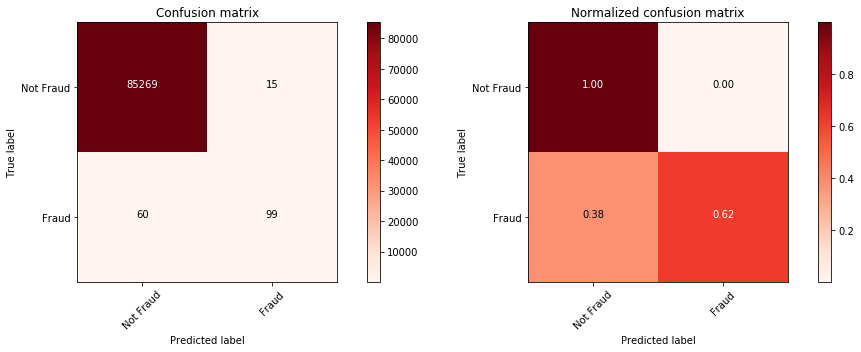

In [10]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')
plt.tight_layout()

As you can see, our model misses fraudulent charges ~40% of the time! That isn't acceptable. Now lets run our regression using our undersampled data and see if we can't improve our fraud detection.

In [11]:
#run a logistic regression on the under sampled data
logr_resampled = LogisticRegression(C=0.01)
logr_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = logr_resampled.predict(X_test_resampled)

print('Resampled Train Score: ', logr_resampled.score(X_train_resampled, y_train_resampled))
print('Resampled Test Score: ', logr_resampled.score(X_test_resampled, y_test_resampled))
print('5 Fold CV Score: ', cross_val_score(logr_resampled, X_test_resampled, y_test_resampled, cv=5))

Resampled Train Score:  0.9331395348837209
Resampled Test Score:  0.9222972972972973
5 Fold CV Score:  [0.95 0.88 0.88 0.92 0.95]


These scores feel a little bit more realistic. Now lets check our confusion matrix and see if our model is better at accurately detecting fraud.

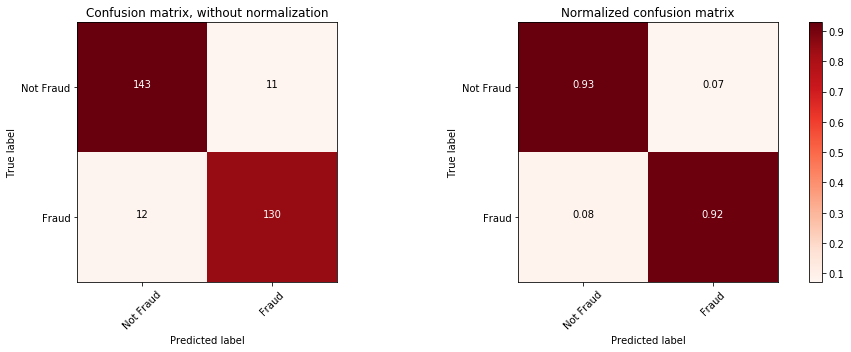

In [12]:
# Compute confusion matrix
cnf_matrix_resampled = confusion_matrix(y_test_resampled, y_pred_resampled)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_resampled, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_resampled, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

This model is much better at accurately predicting fraud! We went from ~40% misses to only about 10%. That's a four fold improvement. Now let's test this model vs our entire test data set.

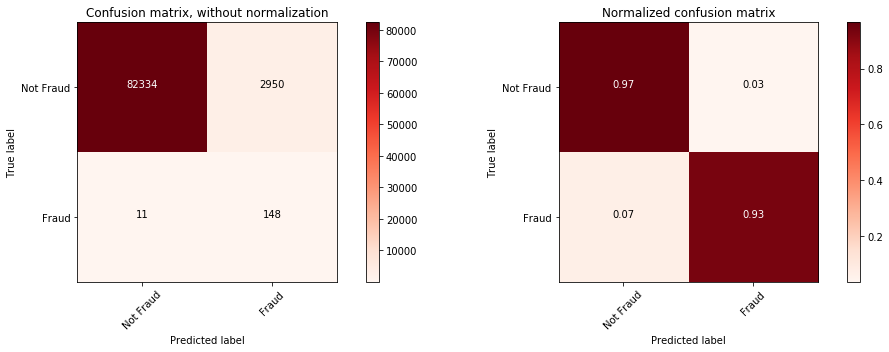

In [13]:
logr_main = LogisticRegression(C=0.01)
logr_main.fit(X_train_resampled, y_train_resampled)
y_pred_main = logr_main.predict(X_test)

# Compute confusion matrix
cnf_matrix_main = confusion_matrix(y_test, y_pred_main)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_main, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_main, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

The logistic regression was able to get down to about 10% error. Let's see if we can improve that with a random forest classifier.

In [14]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
cross_val_score(rfc, X_train, y_train, cv=5)

array([1., 1., 1., 1., 1.])

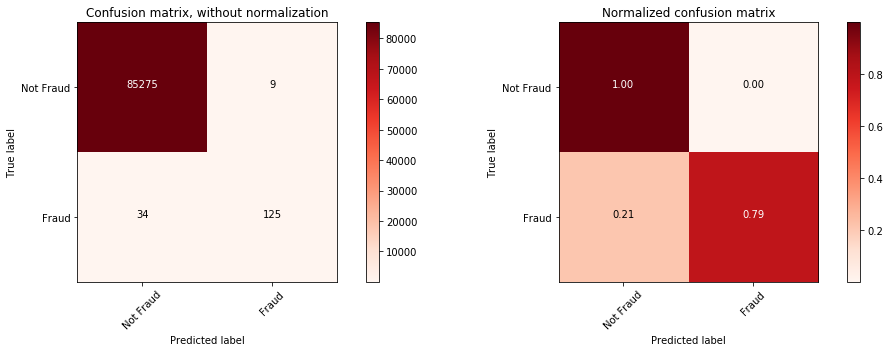

In [15]:
# Compute confusion matrix
cnf_matrix_rfc = confusion_matrix(y_test, rfc_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_rfc, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_rfc, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

In [16]:
rfc_resampled = ensemble.RandomForestClassifier(500)
rfc_resampled.fit(X_train_resampled, y_train_resampled)
rfc_pred_resampled = rfc_resampled.predict(X_test_resampled)
cross_val_score(rfc_resampled, X_train_resampled, y_train_resampled, cv=5)

array([0.95, 0.93, 0.94, 0.93, 0.94])

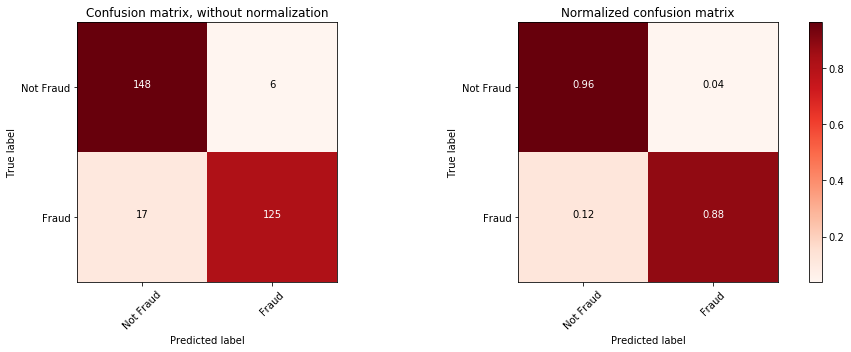

In [17]:
# Compute confusion matrix
cnf_matrix_rfc_resampled = confusion_matrix(y_test_resampled, rfc_pred_resampled)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_rfc_resampled, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_rfc_resampled, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')

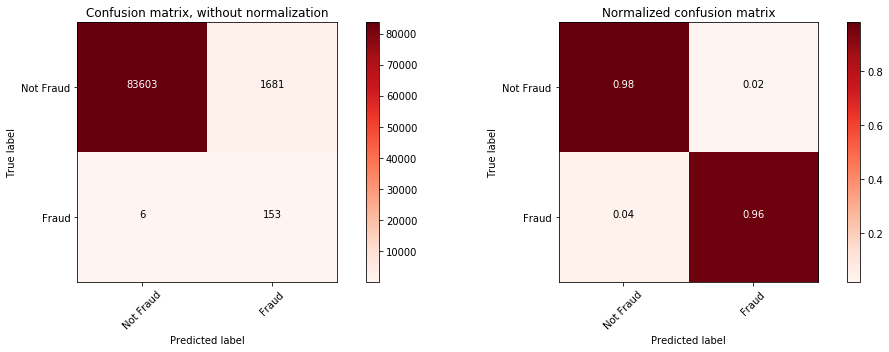

In [18]:
rfc_main = ensemble.RandomForestClassifier(500)
rfc_main.fit(X_train_resampled, y_train_resampled)
rfc_pred_main = rfc_main.predict(X_test)

# Compute confusion matrix
cnf_matrix_rfc_main = confusion_matrix(y_test, rfc_pred_main)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_rfc_main, classes=['Not Fraud', 'Fraud'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_rfc_main, classes=['Not Fraud', 'Fraud'], normalize=True,
                      title='Normalized confusion matrix')